In [ ]:
from __future__ import print_function

#%matplotlib inline
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML
from skimage.io import imsave

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "./output/"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



In [ ]:
# Generator Class

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator class

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
 # Create the generator
 netG = Generator(ngpu).to(device)

 # Handle multi-gpu if desired
 if (device.type == 'cuda') and (ngpu > 1):
     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
# For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
        netD.zero_grad()
            # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
# Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [ ]:
from torchvision.utils import save_image

if not os.path.exists('./gans/'):
    os.mkdir('./gans/')

for i in range(len(img_list)):
    image0 = img_list[i]
    save_image(image0, f'./gans/gan_{i}.jpg')

In [1]:
import argparse
import csv
import os
import random

import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import utils as ut
from loader import MRDataset
from model import AlexNet

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
def extract_predictions(task, plane, path_to_models, train=True):
    """ 
    `extract_predictions`: the method extracts the prediction from the pretrained models

    args:
        task: the tear to be analized (acl, meniscus, abnormal)
        plane: the plane where the tear occured (for example: axial, coronal, sagittal)
        path_to_models: the path where are stored the trained models
        trains=True: boolean to indicate if the loader needs to be from the training set or the validation

    """
    assert task in ['acl', 'meniscus', 'abnormal']
    assert plane in ['axial', 'coronal', 'sagittal']
    
    # Initialize the models and filter by the tear
    models = os.listdir(path_to_models)
    model_name = list(filter(lambda name: task in name and plane in name, models))[0]
    model_path = f'{path_to_models}/{model_name}'

    # Select the gpu or the cpu for the tensor compilation
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else: 
        device = torch.device('cpu')

    model = AlexNet()

    # Load the model
    mrnet = torch.load(model_path)
    model.load_state_dict(mrnet)
    model.to(device)
    model.eval()
    
    # Create the traning set and send to the loader
    dataset = MRDataset('./data/', task, plane, train=train)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2, drop_last=False)

    
    # Create the array list to store the predictions and labels from the compiled model
    predictions = []
    labels = []

    # While compiling without gradient, add each single item from the labels and prediction
    # to the above defined array lists 
    # and then return it 

    with torch.no_grad():
        for image, label, _ in tqdm.tqdm(loader):
            image = image.to(device)
            logit = model(image)
            prediction = torch.sigmoid(logit)
            predictions.append(prediction[0].item())
            labels.append(label[0].item())
    
    return np.argmax(predictions), np.argmax(labels)

In [ ]:
final_results_val = {}

for task in ['acl', 'meniscus', 'abnormal']:
    results = {}

    # Train a logistic regressor model
    for plane in ['axial', 'coronal', 'sagittal']:
        prediction = extract_predictions(task, plane, './experiments/exp_opt_acc/models/')


In [ ]:
# Create a logistic regressor for the validation test
results_val = {}

for plane in ['axial', 'coronal', 'sagittal']:
    predictions, labels = extract_predictions(task, plane, './experiments/exp_opt_acc/models/', train=True)
    results_val['labels'] = labels
    results_val[plane] = predictions

X_val = np.zeros((len(predictions), 3))
X_val[:, 0] = results_val['axial']
X_val[:, 1] = results_val['coronal']
X_val[:, 2] = results_val['sagittal']

y_val = np.array(labels)

y_pred = logreg.predict_proba(X_val)[:, 1]
y_class_preds = (y_pred > 0.5).astype(np.float32)

In [ ]:
import pandas as pd

pre = pd.DataFrame(y_class_preds)

In [ ]:
pre.to_csv('./pred_auc.csv')

In [3]:
acl_acc = pd.read_csv(f'./experiments/exp_opt_acc/results/complex-acl-prediction.csv')
abnormal_acc = pd.read_csv(f'./experiments/exp_opt_acc/results/complex-abnormal-prediction.csv')
meniscus_acc = pd.read_csv(f'./experiments/exp_opt_acc/results/complex-meniscus-prediction.csv')

acl_wu = pd.read_csv(f'./experiments/exp_opt_wu/results/complex-acl-prediction.csv')
abnormal_wu = pd.read_csv(f'./experiments/exp_opt_wu/results/complex-abnormal-prediction.csv')
meniscus_wu = pd.read_csv(f'./experiments/exp_opt_wu/results/complex-meniscus-prediction.csv')

In [4]:
acl_acc = acl_acc.rename(columns={"Unnamed: 0": "Case", "0": "Score"})
abnormal_acc = abnormal_acc.rename(columns={"Unnamed: 0": "Case", "0": "Score"})
meniscus_acc = meniscus_acc.rename(columns={"Unnamed: 0": "Case", "0": "Score"})

acl_wu = acl_wu.rename(columns={"Unnamed: 0": "Case", "0": "Score"})
abnormal_wu = abnormal_wu.rename(columns={"Unnamed: 0": "Case", "0": "Score"})
meniscus_wu = meniscus_wu.rename(columns={"Unnamed: 0": "Case", "0": "Score"})

In [5]:
acl_acc["Prediction"] = acl_acc['Score'] == 1
abnormal_acc["Prediction"] = abnormal_acc['Score'] == 1
meniscus_acc["Prediction"] = meniscus_acc['Score'] == 1


acl_wu["Prediction"] = acl_wu['Score'] == 1
abnormal_wu["Prediction"] = abnormal_wu['Score'] == 1
meniscus_wu["Prediction"] = meniscus_wu['Score'] == 1

In [6]:
acl_acc = acl_acc.set_index('Case')
abnormal_acc = abnormal_acc.set_index('Case')
meniscus_acc = meniscus_acc.set_index('Case')

acl_wu = acl_wu.set_index('Case')
abnormal_wu = abnormal_wu.set_index('Case')
meniscus_wu = meniscus_wu.set_index('Case')

In [7]:
print('Acl Accuracy')
print(acl_acc.loc[acl_acc['Score'] != acl_wu['Score']])
print('-'*30)
print('\nAcl WU')
print(acl_wu.loc[acl_acc['Score'] != acl_wu['Score']])

Acl Accuracy
      Score  Prediction
Case                   
150     1.0        True
298     1.0        True
325     1.0        True
------------------------------

Acl WU
      Score  Prediction
Case                   
150     0.0       False
298     0.0       False
325     0.0       False


In [9]:
print('Abnormal Accuracy')
print(abnormal_acc.loc[abnormal_acc['Score'] != abnormal_wu['Score']])
print('-'*30)
print('\nAbnormal WU')
print(abnormal_wu.loc[abnormal_acc['Score'] != abnormal_wu['Score']])

Abnormal Accuracy
      Score  Prediction
Case                   
77      0.0       False
230     0.0       False
258     0.0       False
280     0.0       False
309     0.0       False
------------------------------

Abnormal WU
      Score  Prediction
Case                   
77      1.0        True
230     1.0        True
258     1.0        True
280     1.0        True
309     1.0        True


In [10]:
print('Meniscus Accuracy')
print(meniscus_acc.loc[meniscus_acc['Score'] != meniscus_wu['Score']])
print('-'*30)
print('\nMeniscus WU')
print(meniscus_wu.loc[meniscus_acc['Score'] != meniscus_wu['Score']])

Meniscus Accuracy
      Score  Prediction
Case                   
94      1.0        True
97      1.0        True
150     1.0        True
259     1.0        True
325     1.0        True
------------------------------

Meniscus WU
      Score  Prediction
Case                   
94      0.0       False
97      0.0       False
150     0.0       False
259     0.0       False
325     0.0       False


In [11]:
acl_acc.to_csv(f'./experiments/exp_opt_acc/results/complex-acl-prediction.csv')
abnormal_acc.to_csv(f'./experiments/exp_opt_acc/results/complex-abnormal-prediction.csv')
meniscus_acc.to_csv(f'./experiments/exp_opt_acc/results/complex-meniscus-prediction.csv')

acl_wu.to_csv(f'./experiments/exp_opt_wu/results/complex-acl-prediction.csv')
abnormal_wu.to_csv(f'./experiments/exp_opt_wu/results/complex-abnormal-prediction.csv')
meniscus_wu.to_csv(f'./experiments/exp_opt_wu/results/complex-meniscus-prediction.csv')

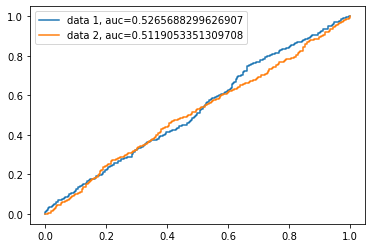

In [1]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)

In [19]:
import numpy as np
import os
from PIL import Image
from scipy.misc import imsave

In [28]:

axial = './data/train/axial/'
count = 0

for image in os.listdir(axial):
    img = os.path.join(axial, image)
    img = np.load(img)
    for i in range(img.shape[0]):
        arr = Image.fromarray(img[i, :, :])
        arr.save(f'./images/axial/{image}-{i}.jpg')

In [29]:

coronal = './data/train/coronal/'
count = 0

for image in os.listdir(coronal):
    img = os.path.join(coronal, image)
    img = np.load(img)
    for i in range(img.shape[0]):
        arr = Image.fromarray(img[i, :, :])
        arr.save(f'./images/coronal/{image}-{i}.jpg')

In [30]:

sagittal = './data/train/sagittal/'
count = 0

for image in os.listdir(sagittal):
    img = os.path.join(sagittal, image)
    img = np.load(img)
    for i in range(img.shape[0]):
        arr = Image.fromarray(img[i, :, :])
        arr.save(f'./images/sagittal/{image}-{i}.jpg')